# Librerías

In [1]:
# packages
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV

from xgboost import XGBClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier

from utils.resample import resample
from utils.train_model import train_model

# seed
random_state = 3380

# supress warnings
import warnings
warnings.filterwarnings("ignore")

# Lectura de datos

In [2]:
# read data
df = pd.read_csv('challenge/dataset_SCL.csv', sep = ',', dtype = {'Vio-I': 'category', 'Ori-I': 'category', 'Des-I': 'category',
                                                                  'Emp-I': 'category', 'Vio-O': 'category', 'Ori-O': 'category',
                                                                  'Des-O': 'category', 'Emp-O': 'category', 'DIANOM': 'category',
                                                                  'TIPOVUELO': 'category', 'OPERA': 'category', 'SIGLAORI': 'category',
                                                                  'SIGLADES': 'category', 
                                                                  #'DIA': 'category', 'MES': 'category', 'AÑO': 'category',
                                                                  })

# transform to datetime format
df['Fecha-I'] = pd.to_datetime(df['Fecha-I'])
df['Fecha-O'] = pd.to_datetime(df['Fecha-O'])

# sample of data
df.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami


# 1. ¿How is the data distributed? 

In [3]:
print(f'The dataset contains {df.shape[0]} rows and {df.shape[1]} features!')

The dataset contains 68206 rows and 18 features!


In [4]:
df['SIGLAORI'].value_counts()

Santiago    68206
Name: SIGLAORI, dtype: int64

The dataset contains only departures from Santiago, not arrivals. Let´s see how those departures are distributed

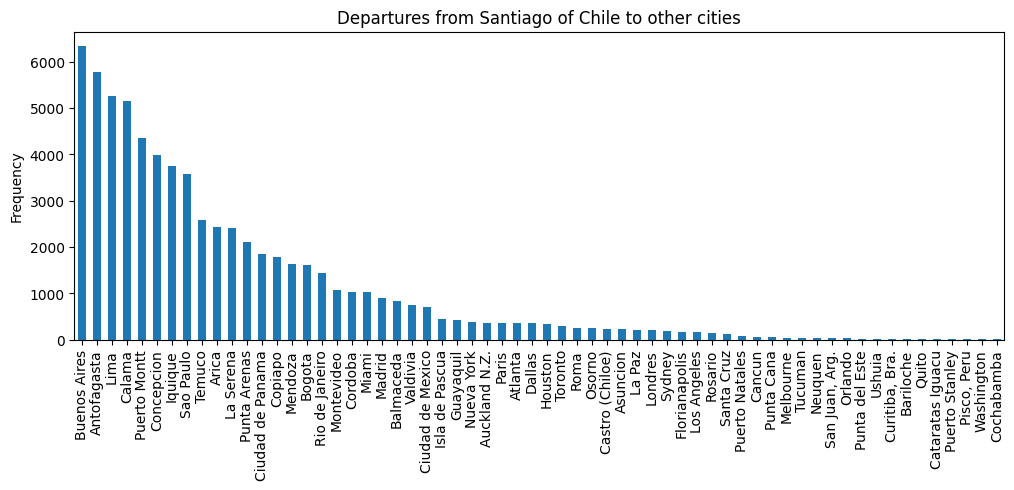

In [5]:
plt.figure(figsize = (12, 4))
df['SIGLADES'].value_counts().plot.bar()
plt.title('Departures from Santiago of Chile to other cities')
plt.ylabel('Frequency')
plt.show()

Apparently, the departures from Santiago are concentrated on destinations within `South America`. On that regard, it is noted that the majority of flights are local, with some expectable exceptions like departures to `Buenos Aires` or `Lima`.

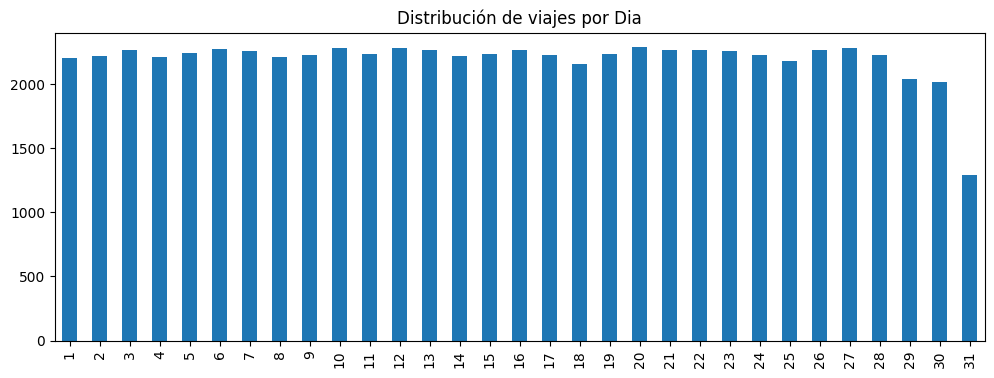

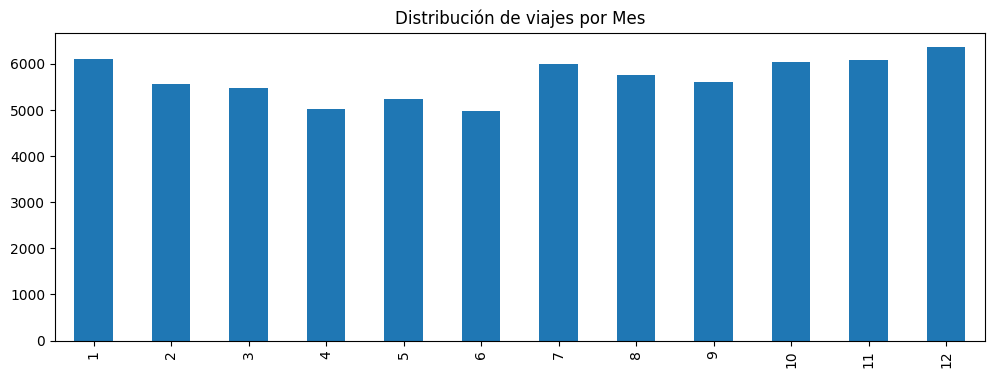

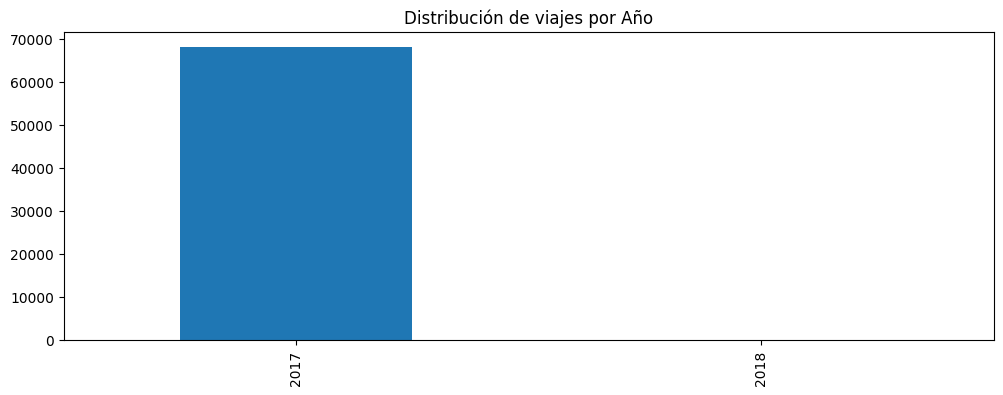

In [6]:
for feature in ['DIA', 'MES', 'AÑO']:
    plt.figure(figsize = (12, 4))
    df[feature].value_counts().sort_index().plot.bar()
    plt.title(f'Distribución de viajes por {feature.title()}')
    plt.show()


Del gráfico anterior, se observa:

- La cantidad de viajes por `DIA` se distribuye de manera relativamente homógenea, con una moderada disminución en los últimos días del mes. Esto puede ser explicado en que los últimos días del mes (29, 30 y 31) no están presentes en todos los meses del año.
- La cantidad de viajes por `MES` se distribuye con leves diferencias entre cada mes, siendo los meses con mayor cantidad de vuelos Diciembre, Enero y Julio.
- La cantidad de viajes por `AÑO` es casi en la totalidad orientada hacia el año 2017, donde tan solo 2 viajes de los 68.206 viajes en el dataset son del año 2018.

In [7]:
df['año_mes'] = df.apply(lambda x: str(x['AÑO']) + '_' + str(x['MES']), axis = 1)
df.groupby('año_mes').count()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES
año_mes,,,,,,,,,,,,,,,,,,
2017_1,6106,6106,6106,6106,6106,6106,6105,6106,6106,6106,6106,6106,6106,6106,6106,6106,6106,6106
2017_10,6032,6032,6032,6032,6032,6032,6032,6032,6032,6032,6032,6032,6032,6032,6032,6032,6032,6032
2017_11,6080,6080,6080,6080,6080,6080,6080,6080,6080,6080,6080,6080,6080,6080,6080,6080,6080,6080
2017_12,6356,6356,6356,6356,6356,6356,6356,6356,6356,6356,6356,6356,6356,6356,6356,6356,6356,6356
2017_2,5561,5561,5561,5561,5561,5561,5561,5561,5561,5561,5561,5561,5561,5561,5561,5561,5561,5561
2017_3,5482,5482,5482,5482,5482,5482,5482,5482,5482,5482,5482,5482,5482,5482,5482,5482,5482,5482
2017_4,5020,5020,5020,5020,5020,5020,5020,5020,5020,5020,5020,5020,5020,5020,5020,5020,5020,5020
2017_5,5240,5240,5240,5240,5240,5240,5240,5240,5240,5240,5240,5240,5240,5240,5240,5240,5240,5240
2017_6,4981,4981,4981,4981,4981,4981,4981,4981,4981,4981,4981,4981,4981,4981,4981,4981,4981,4981


In [8]:
df.isnull().sum()

Fecha-I      0
Vlo-I        0
Ori-I        0
Des-I        0
Emp-I        0
Fecha-O      0
Vlo-O        1
Ori-O        0
Des-O        0
Emp-O        0
DIA          0
MES          0
AÑO          0
DIANOM       0
TIPOVUELO    0
OPERA        0
SIGLAORI     0
SIGLADES     0
año_mes      0
dtype: int64

# 2. Generate new features

In [9]:
# we define date variables
dec_15 = datetime.date(2017, 12, 15) # Dec-15 2017
mar_3 = datetime.date(2017, 3, 3) # Mar-3 2017
jul_15 = datetime.date(2017, 7, 15) # Jul-15 2017
jul_31 = datetime.date(2017, 7, 31) # Jul-31 2017
sep_11 = datetime.date(2017, 9, 11) # Sep-11 2017
sep_30 = datetime.date(2017, 9, 30) # Sep-30 2017
mar_3_2018 = datetime.date(2018, 3, 3) # Mar-3 2018

# and time variables
am_5 = datetime.time(5, 0) # 5:00 am
am_11 = datetime.time(11, 59) # 11:59 am
pm_12 = datetime.time(12, 0) # 12:00 pm
pm_18 = datetime.time(18, 59) # 18:59 pm
pm_19 = datetime.time(19, 0) # 19:00 pm
am_4 = datetime.time(4, 59) # 4:59 am


df['high_season'] = df['Fecha-I'].apply(lambda x: 1 if (x.date() >= dec_15 or x.date() <= mar_3) 
                                        | (x.date() >= jul_15 and x.date() <= jul_31) 
                                        | (x.date() >= sep_11 and x.date() <= sep_30) 
                                        | (x.year == 2018 and x.date() <= mar_3_2018) # border case from 2 obs belonging to 2018
                                        else 0) 
df['min_diff'] = df.apply(lambda x: (x['Fecha-O'] - x['Fecha-I']).total_seconds() / 60, axis = 1)
df['delay_15'] = np.where(df['min_diff'] > 15, 1, 0)
df['period_day'] = df['Fecha-I'].apply(lambda x: 'morning' if (x.time() >= am_5 and x.time() <= am_11) else 
                                       'afternoon' if (x.time() >= pm_12 and x.time() <= pm_18) else
                                       'night' if (x.time() >= pm_19 or x.time() <= am_4)
                                       else np.nan)


new_features = ['high_season', 'min_diff', 'delay_15', 'period_day']
df[['Fecha-I', 'Fecha-O'] + new_features].to_csv('synthetic_features.csv', sep = ';', encoding = 'utf-8-sig', index = False)



# 3. Behavior of delay rate across features

In [10]:
df['TIPOVUELO'] = df['TIPOVUELO'].apply(lambda x: 'National' if x == 'N' else 'International' if x == 'I' else x)

0    0.81506
1    0.18494
Name: delay_15, dtype: float64


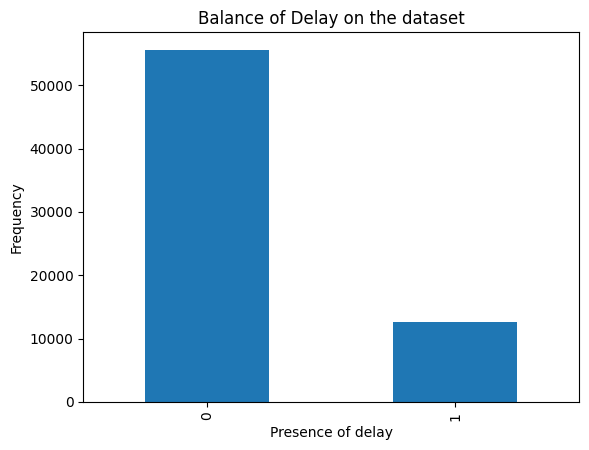

In [11]:
print(df['delay_15'].value_counts() / df.shape[0])

df['delay_15'].value_counts().plot.bar()
plt.title('Balance of Delay on the dataset')
plt.xlabel('Presence of delay')
plt.ylabel('Frequency')
plt.show()

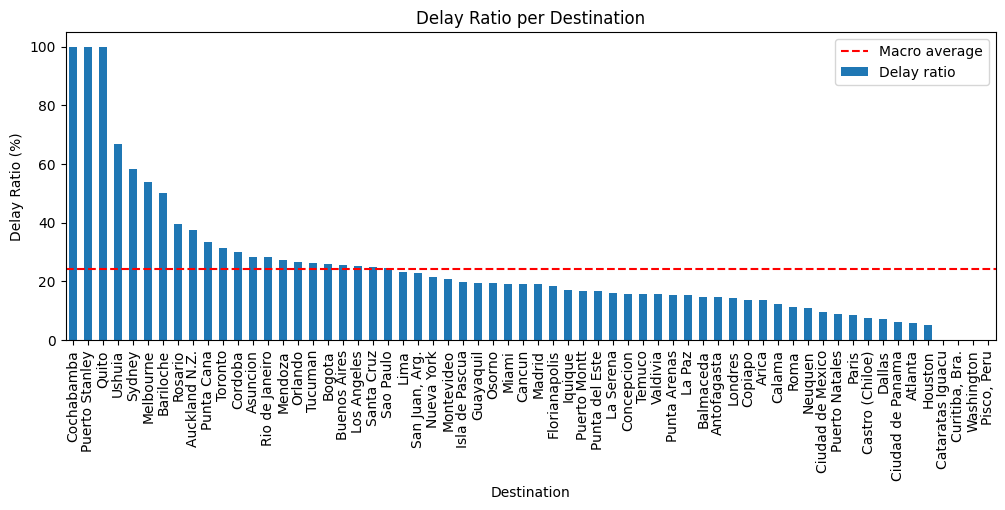

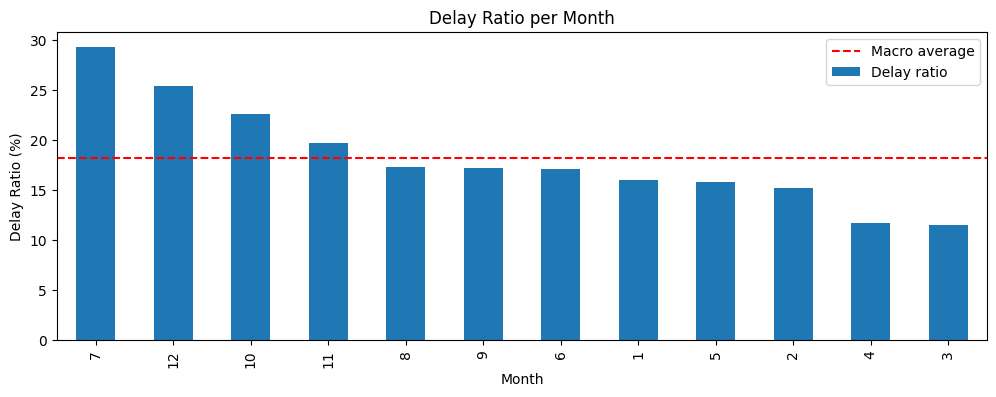

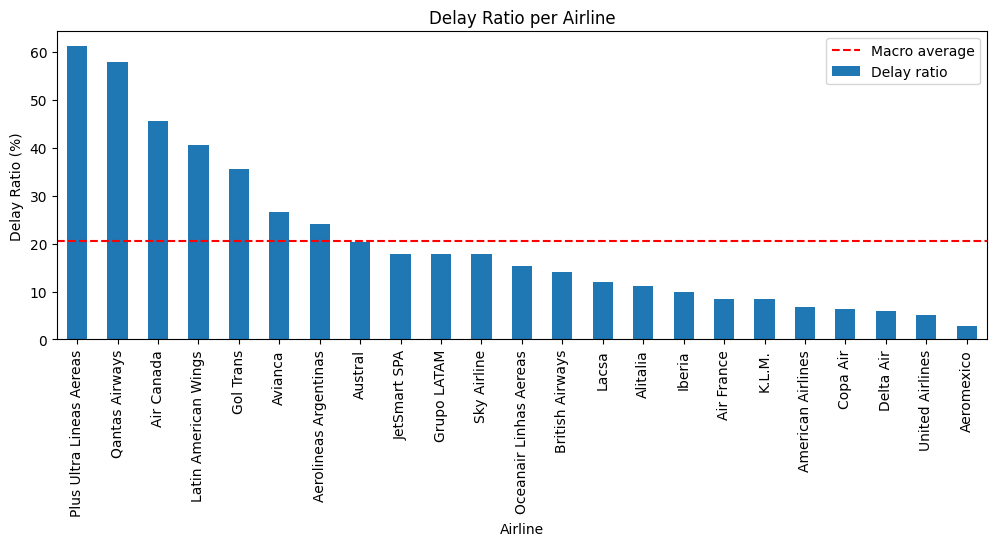

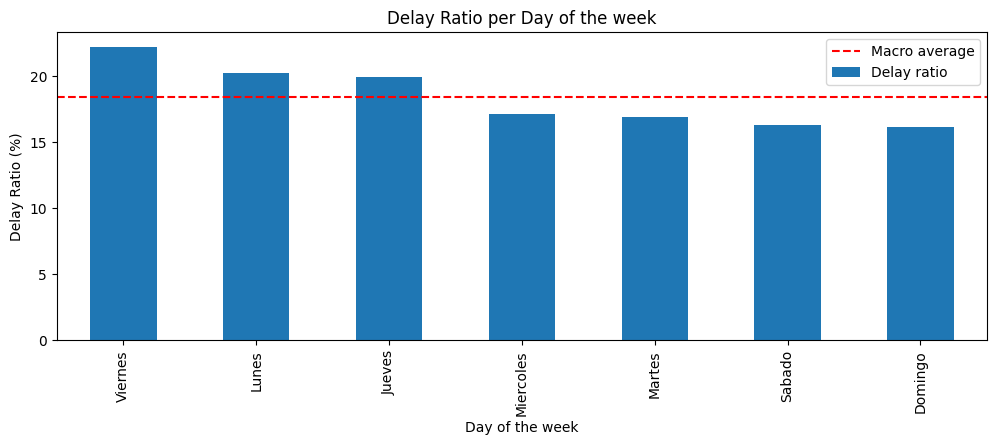

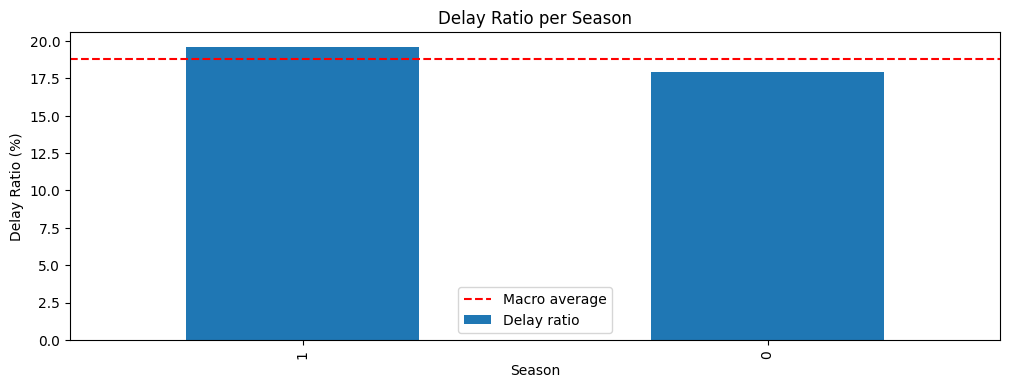

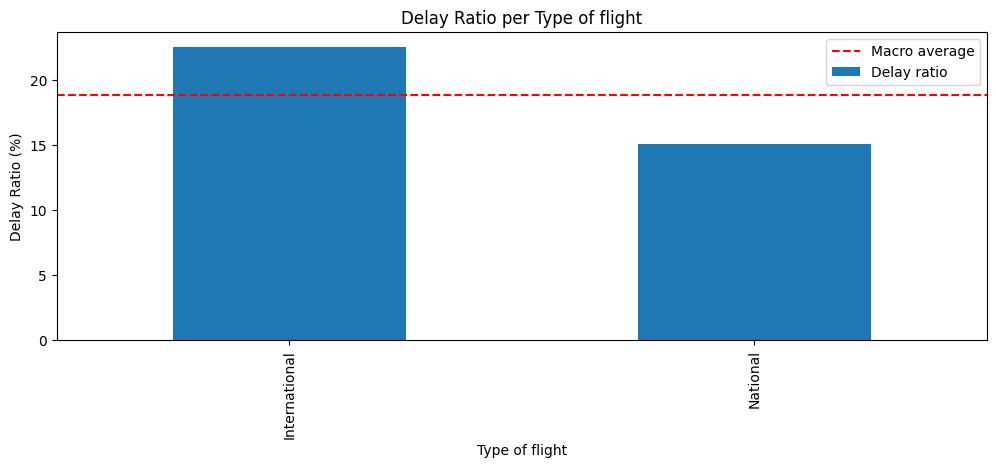

In [12]:
def plot_ratio(feature, title, xlabel):
    plt.figure(figsize = (12, 4))
    (df.groupby(feature).mean()['delay_15'].sort_values(ascending = False) * 100).plot(kind = 'bar', label = 'Delay ratio')
    plt.axhline(df.groupby(feature).mean()['delay_15'].mean()*100, color = 'r', label = 'Macro average', linestyle = '--')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Delay Ratio (%)')
    plt.legend()

plot_ratio(feature = 'SIGLADES', title = 'Delay Ratio per Destination', xlabel = 'Destination')
plot_ratio(feature = 'MES', title = 'Delay Ratio per Month', xlabel = 'Month')
plot_ratio(feature = 'OPERA', title = 'Delay Ratio per Airline', xlabel = 'Airline')
plot_ratio(feature = 'DIANOM', title = 'Delay Ratio per Day of the week', xlabel = 'Day of the week')
plot_ratio(feature = 'high_season', title = 'Delay Ratio per Season', xlabel = 'Season')
plot_ratio(feature = 'TIPOVUELO', title = 'Delay Ratio per Type of flight', xlabel = 'Type of flight')

# 4. Likelihood of delay

In [13]:
df['AÑO'] = pd.Categorical(df['AÑO'])
df['MES'] = pd.Categorical(df['MES'])
df['DIA'] = pd.Categorical(df['DIA'])

In [14]:
ordinal_vars = ['DIA', 'MES', 'AÑO']
ordinal_cat = [[category for category in df[var].cat.categories] for var in ordinal_vars]
categoric_vars = [column for column in df.select_dtypes('category').columns if column not in ordinal_vars]

# we define pipelines for each data type
categoric_pipe = Pipeline([
                         ('onehot', OneHotEncoder(handle_unknown = 'ignore')),
                         ])

ordinal_pipe = Pipeline([
                         ('encoder', OrdinalEncoder(categories = ordinal_cat)),
                         ])

# we use the pipelines together with ColumnTransformer
preprocessor = ColumnTransformer([
                                  ('categoric', categoric_pipe, categoric_vars),
                                  ('ordinal', ordinal_pipe, ordinal_vars)
])


# consolidate pipelines with clfs

baseline_pipe = Pipeline([
                  ('preprocessing', preprocessor),
                  ('clf', DummyClassifier(strategy = 'stratified')),
                  ])

xgboost_pipe = Pipeline([
                  ('preprocessing', preprocessor),
                  ('clf', XGBClassifier(random_state = random_state)),
                  ])

lightgbm_pipe = Pipeline([
                  ('preprocessing', preprocessor),
                  ('clf', LGBMClassifier(random_state = random_state)),
                  ])

## Baseline model

Con el fin de tener un punto de comparación para luego evaluar la calidad de nuestros modelos, usaremos como benchmark un modelo `DummyClassifier`, el cual genera sus predicciones usando la proporción de clases en el dataset.

In [15]:
train_model(df = df, target = 'delay_15', pipeline = baseline_pipe, random_state = 3380)

F1: 0.502
              precision    recall  f1-score   support

           0       0.82      0.81      0.81     18345
           1       0.19      0.19      0.19      4163

    accuracy                           0.70     22508
   macro avg       0.50      0.50      0.50     22508
weighted avg       0.70      0.70      0.70     22508



0.5019894882886058

## Preprocessing Optimization

In [30]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.WARNING)

def objective(trial):
    params = {
        'param_under': trial.suggest_float(name = 'param_under', low = 0.0, high = 1.0, step = 0.05),
        'param_over': trial.suggest_float(name = 'param_over', low = 0.0, high = 1.0, step = 0.05)
        }
    
    return train_model(df = df, target = 'delay_15', pipeline = xgboost_pipe, random_state = random_state, report = False, **params)

study = optuna.create_study(direction = 'maximize', sampler = TPESampler())
study.optimize(objective, n_trials = 50, show_progress_bar = True)

Best trial: 12. Best value: 0.622342: 100%|██████████| 50/50 [01:56<00:00,  2.33s/it]


In [32]:
best_trial = study.best_trial
print(f'Best params: {best_trial.params}')
print(f'Best F1: {best_trial.value}')

Best params: {'param_under': 0.5, 'param_over': 0.30000000000000004}
Best F1: 0.6223416654348464


## Hyperparameter Optimization

In [33]:
train_model(df = df, target = 'delay_15', pipeline = xgboost_pipe, param_under = 0.5, param_over = 0.3, random_state = random_state)

F1: 0.622
              precision    recall  f1-score   support

           0       0.86      0.87      0.86     18345
           1       0.39      0.37      0.38      4163

    accuracy                           0.78     22508
   macro avg       0.62      0.62      0.62     22508
weighted avg       0.77      0.78      0.77     22508



0.6223416654348464

# 5. Evaluate performance and Discussion

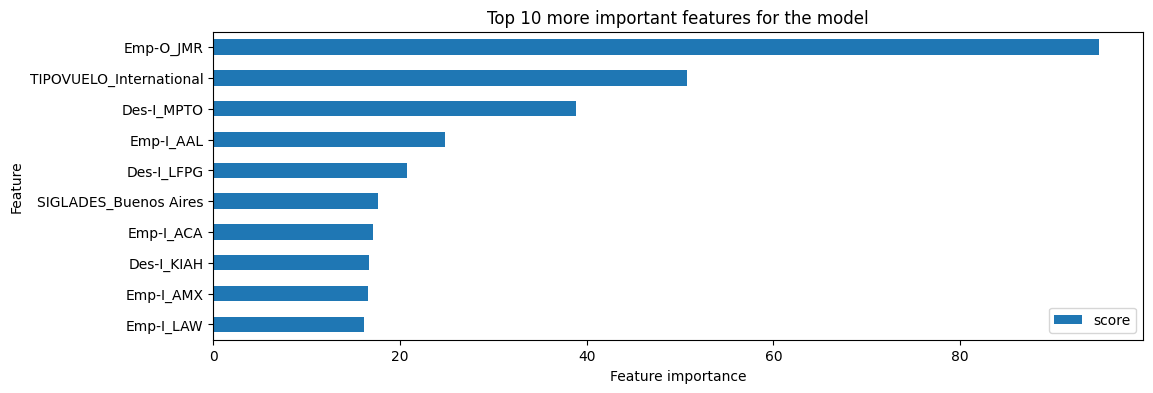

In [18]:
# we recover the features names of the preprocessing step
onehot_features = xgboost_pipe['preprocessing'].transformers_[0][1]['onehot'].get_feature_names_out()
ordinal_features = xgboost_pipe['preprocessing'].transformers_[1][1]['encoder'].get_feature_names_out()

# generate a dict to transform map features from xgboost to the original names
features_names = list(onehot_features) + list(ordinal_features)
features_dict = {f'f{i}': features_names[i] for i in range(len(features_names))}

# we get the features importances of the model
importances = xgboost_pipe['clf'].get_booster().get_score(importance_type = 'gain')
keys = [features_dict[key] for key in importances.keys()]
values = list(importances.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(10, columns="score").sort_values(by = 'score', ascending = True).plot(kind='barh', figsize = (12,4)) # plot top 40 features
plt.title('Top 10 more important features for the model')
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()